In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
from torch import nn, tensor
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import transforms, ToTensor
import torchvision.utils as vutils


LATENT = 32
DIMS_E = [16, 32, 64, 32]
DIMS_G = [32, 64, 32, 16]
DIMS_D = [16, 32, 64, 32]
# DIMS_E = [32, 64, 96, 64]
# DIMS_G = [64, 96, 64, 32]
# DIMS_D = [8, 16, 24, 16]
MODEL_E_PATH = "ffhq-64x64-e.pth"
MODEL_G_PATH = "ffhq-64x64-g.pth"
MODEL_D_PATH = "ffhq-64x64-d.pth"
EXPORT_PATH = "raw-weights-ffhq-64x64"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [2]:

class FFHQDataset(Dataset):

    def __init__(self, transform=None, target_transform=None):
        self.size = 64
        self.path = f"../data/FFHQ/{self.size}x{self.size}/"
        self.raw_bytes = {}
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        #return 10000
        return 70000

    def __getitem__(self, i):
        bd = i - i % 1000
        filepath = self.path + "{:05d}.raw".format(bd)
        if filepath not in self.raw_bytes:
            content = np.fromfile(filepath, dtype=np.uint8)
            content = content.reshape((1000, 3, self.size, self.size))
            self.raw_bytes[filepath] = content
        else:
            content = self.raw_bytes[filepath]
        return content[i%1000].astype(np.float32) / 255.0


def load_data(dataset, plot=False):
    dataloader = DataLoader(
        dataset,
        batch_size=128,
        shuffle=True
    )
    for x in dataloader:
        print("Shape of x:", x.shape)
        break
    if plot:
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(
            next(iter(dataloader)).to(device)[:64],
            padding=2, pad_value=0.5, normalize=True).cpu(), (1, 2, 0)),
                   interpolation='nearest')
        plt.show()
    return dataloader


In [4]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        dims = DIMS_E
        self.main = nn.Sequential(
            # 3 x 64x64
            nn.Conv2d(3, dims[0], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[0]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[0] x 32x32
            nn.Conv2d(dims[0], dims[1], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[1] x 16x16
            nn.Conv2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[2] x 8x8
            nn.Conv2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[3] x 4x4
            nn.Conv2d(dims[3], LATENT, 4, 1, 0, bias=False),
            nn.Flatten()
        )

    def forward(self, x):
        return self.main(x)


class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        # ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
        dims = DIMS_G
        layers = [
            # LATENT
            nn.Linear(LATENT, dims[0]*4*4, bias=False),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Unflatten(1, (dims[0], 4, 4)),
            # dims[0] x 4x4
            nn.ConvTranspose2d(dims[0], dims[1], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[1] x 8x8
            nn.ConvTranspose2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[2] x 16x16
            nn.ConvTranspose2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            nn.LeakyReLU(0.1, inplace=True),
            # dims[3] x 32x32
            nn.ConvTranspose2d(dims[3], 3, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # 3 x 64x64
        ]
        layers = [layer for layer in layers if layer is not None]
        self.main = nn.Sequential(*layers)

    def forward(self, x):
        return self.main(x)


class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        dims = DIMS_D
        self.main = nn.Sequential(
            # 3 x 64x64
            nn.Conv2d(3, dims[0], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[0]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[0] x 32x32
            nn.Conv2d(dims[0], dims[1], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[1]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[1] x 16x16
            nn.Conv2d(dims[1], dims[2], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[2]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[2] x 8x8
            nn.Conv2d(dims[2], dims[3], 4, 2, 1, bias=False),
            nn.BatchNorm2d(dims[3]),
            nn.LeakyReLU(0.2, inplace=True),
            # dims[3] x 4x4
            nn.Conv2d(dims[3], 1, 4, 1, 0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


Shape of x: torch.Size([128, 3, 64, 64])
Encoder 91168
Encoder(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=Tru

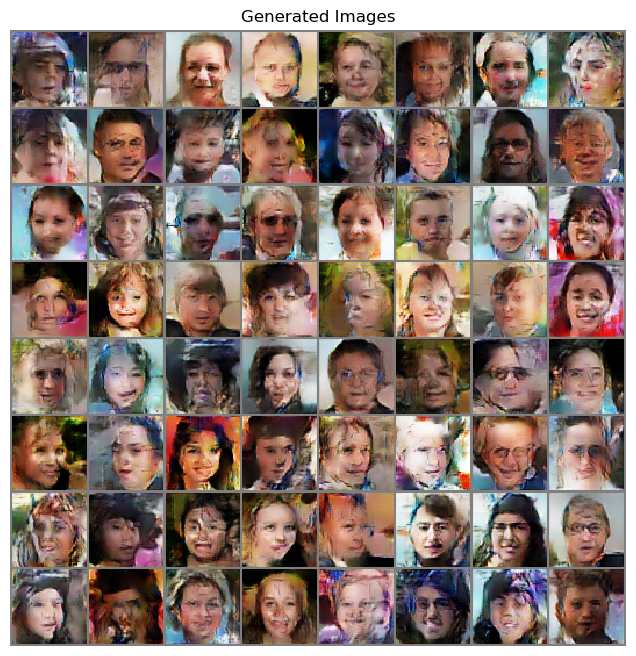

Epoch 2
[100/547]  loss_diff=0.3238 loss_vae=0.0252 loss_d=0.0008 loss_d_eg=0.0343 loss=0.3833
[200/547]  loss_diff=0.3231 loss_vae=0.0255 loss_d=0.0002 loss_d_eg=0.0420 loss=0.3906
[300/547]  loss_diff=0.3201 loss_vae=0.0236 loss_d=0.0007 loss_d_eg=0.0334 loss=0.3771
[400/547]  loss_diff=0.3207 loss_vae=0.0255 loss_d=0.0003 loss_d_eg=0.0459 loss=0.3922
[500/547]  loss_diff=0.3249 loss_vae=0.0256 loss_d=0.0009 loss_d_eg=0.0240 loss=0.3746


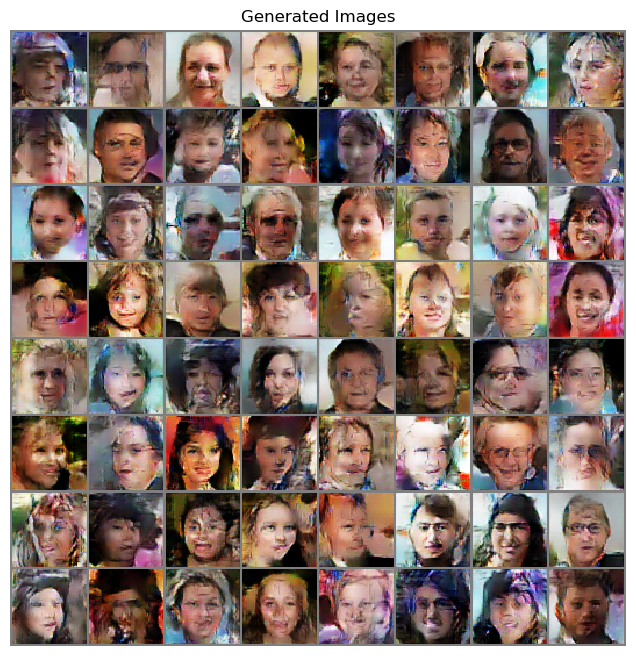

Epoch 3
[100/547]  loss_diff=0.3206 loss_vae=0.0251 loss_d=0.0004 loss_d_eg=0.0352 loss=0.3809
[200/547]  loss_diff=0.3210 loss_vae=0.0255 loss_d=0.0008 loss_d_eg=0.0399 loss=0.3863
[300/547]  loss_diff=0.3278 loss_vae=0.0265 loss_d=0.0008 loss_d_eg=0.0339 loss=0.3881
[400/547]  loss_diff=0.4323 loss_vae=0.1621 loss_d=0.0001 loss_d_eg=0.0589 loss=0.6533
[500/547]  loss_diff=0.3443 loss_vae=0.0546 loss_d=0.0001 loss_d_eg=0.0581 loss=0.4570


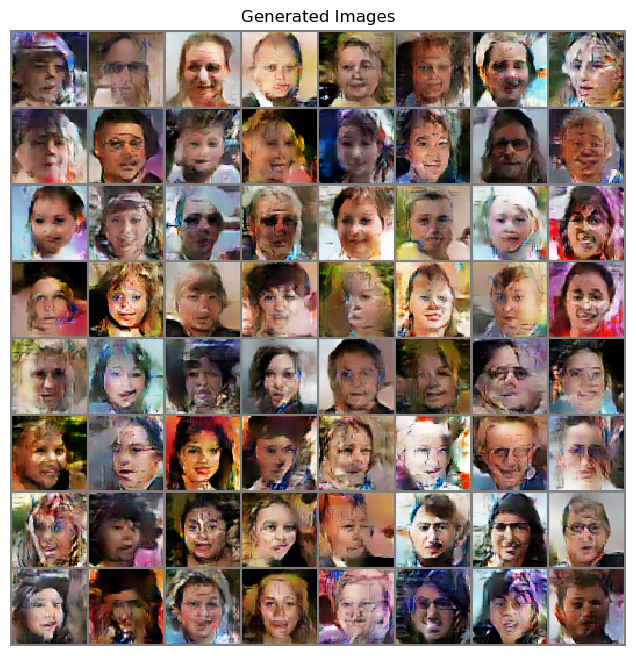

Epoch 4
[100/547]  loss_diff=0.3491 loss_vae=0.0296 loss_d=0.0010 loss_d_eg=0.0284 loss=0.4071
[200/547]  loss_diff=0.3317 loss_vae=0.0285 loss_d=0.0004 loss_d_eg=0.0383 loss=0.3986
[300/547]  loss_diff=0.3346 loss_vae=0.0261 loss_d=0.0004 loss_d_eg=0.0398 loss=0.4005
[400/547]  loss_diff=0.3194 loss_vae=0.0247 loss_d=0.0003 loss_d_eg=0.0540 loss=0.3981
[500/547]  loss_diff=0.3346 loss_vae=0.0235 loss_d=0.0004 loss_d_eg=0.0439 loss=0.4020


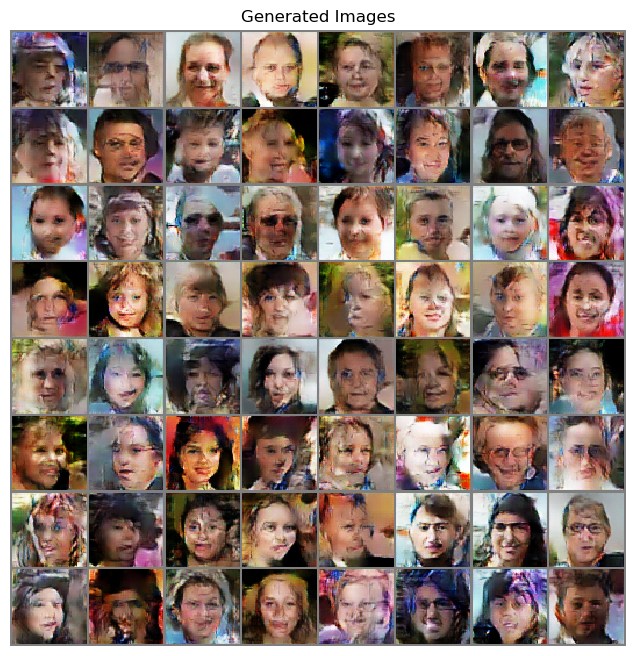

Epoch 5
[100/547]  loss_diff=0.3297 loss_vae=0.0277 loss_d=0.0003 loss_d_eg=0.0436 loss=0.4009
[200/547]  loss_diff=0.3218 loss_vae=0.0246 loss_d=0.0001 loss_d_eg=0.0506 loss=0.3970
[300/547]  loss_diff=0.3304 loss_vae=0.0238 loss_d=0.0002 loss_d_eg=0.0415 loss=0.3958
[400/547]  loss_diff=0.3254 loss_vae=0.0242 loss_d=0.0002 loss_d_eg=0.0593 loss=0.4089
[500/547]  loss_diff=0.3190 loss_vae=0.0234 loss_d=0.0004 loss_d_eg=0.0420 loss=0.3844


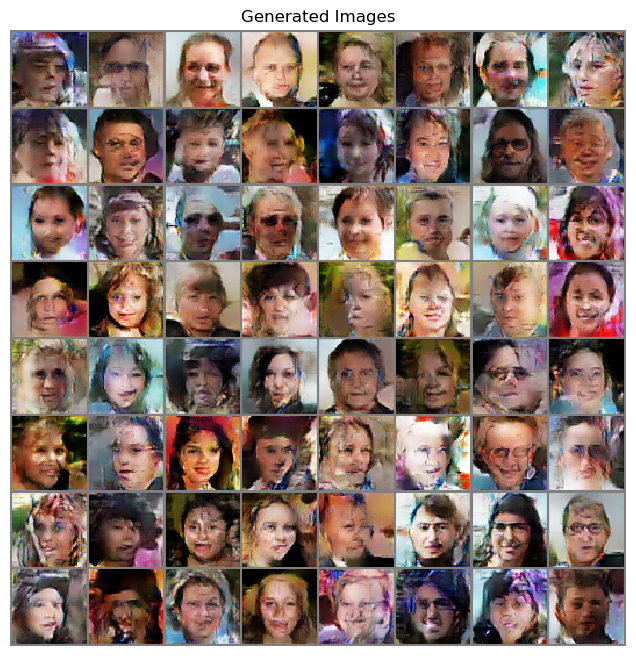

Epoch 6
[100/547]  loss_diff=0.3236 loss_vae=0.0246 loss_d=0.0002 loss_d_eg=0.0431 loss=0.3914
[200/547]  loss_diff=0.3096 loss_vae=0.0250 loss_d=0.0001 loss_d_eg=0.0564 loss=0.3910
[300/547]  loss_diff=0.3200 loss_vae=0.0254 loss_d=0.0001 loss_d_eg=0.0478 loss=0.3932
[400/547]  loss_diff=0.3196 loss_vae=0.0237 loss_d=0.0001 loss_d_eg=0.0471 loss=0.3905
[500/547]  loss_diff=0.3254 loss_vae=0.0258 loss_d=0.0001 loss_d_eg=0.0557 loss=0.4069


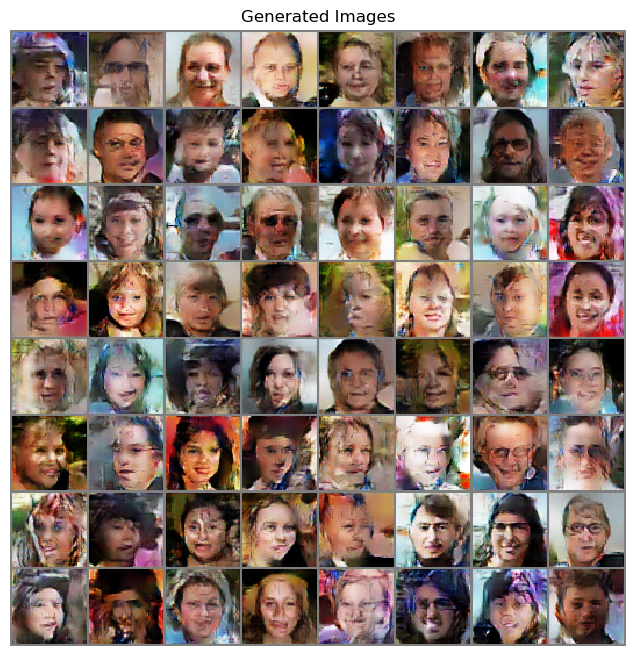

Epoch 7
[100/547]  loss_diff=0.3579 loss_vae=0.0537 loss_d=0.0001 loss_d_eg=0.0574 loss=0.4690
[200/547]  loss_diff=0.3332 loss_vae=0.0276 loss_d=0.0003 loss_d_eg=0.0529 loss=0.4137
[300/547]  loss_diff=0.3264 loss_vae=0.0253 loss_d=0.0005 loss_d_eg=0.0317 loss=0.3834
[400/547]  loss_diff=0.3147 loss_vae=0.0258 loss_d=0.0001 loss_d_eg=0.0526 loss=0.3932
[500/547]  loss_diff=0.3284 loss_vae=0.0240 loss_d=0.0003 loss_d_eg=0.0476 loss=0.4000


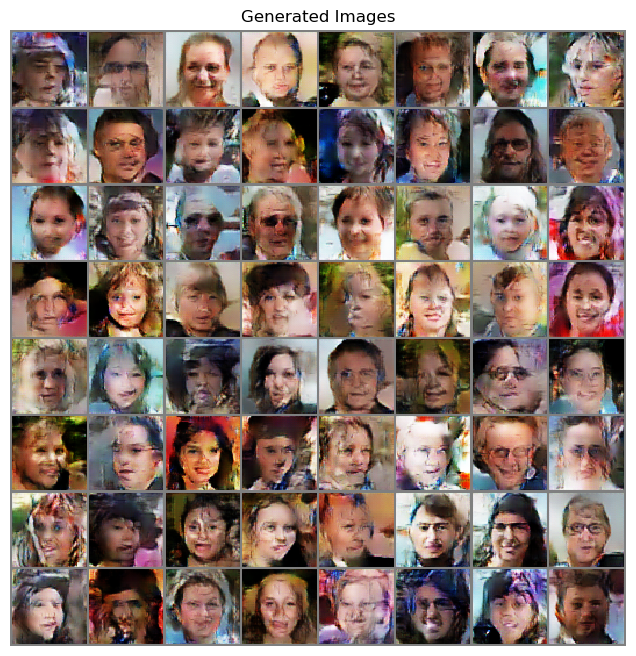

Epoch 8
[100/547]  loss_diff=0.3301 loss_vae=0.0260 loss_d=0.0002 loss_d_eg=0.0479 loss=0.4040
[200/547]  loss_diff=0.3310 loss_vae=0.0400 loss_d=0.0001 loss_d_eg=0.0599 loss=0.4308
[300/547]  loss_diff=0.3374 loss_vae=0.0245 loss_d=0.0002 loss_d_eg=0.0607 loss=0.4225
[400/547]  loss_diff=0.3367 loss_vae=0.0257 loss_d=0.0001 loss_d_eg=0.0544 loss=0.4168
[500/547]  loss_diff=0.3195 loss_vae=0.0238 loss_d=0.0002 loss_d_eg=0.0531 loss=0.3964


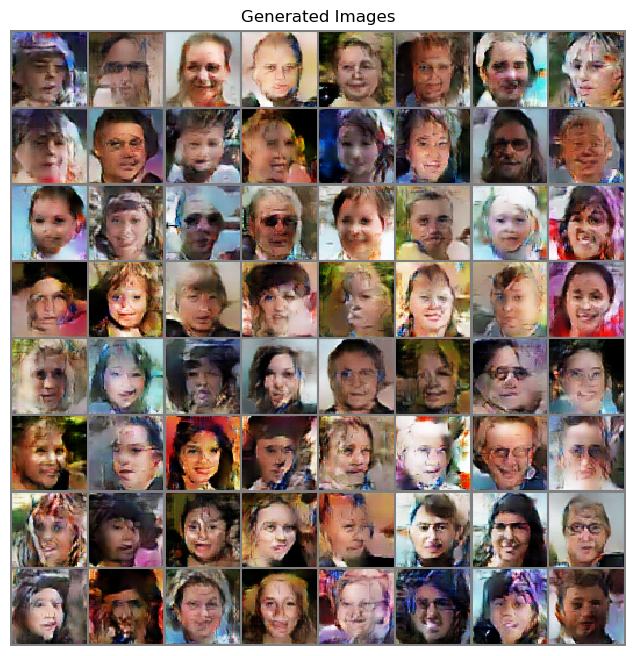

Epoch 9
[100/547]  loss_diff=0.3245 loss_vae=0.0267 loss_d=0.0005 loss_d_eg=0.0469 loss=0.3981
[200/547]  loss_diff=0.3319 loss_vae=0.0240 loss_d=0.0003 loss_d_eg=0.0385 loss=0.3944
[300/547]  loss_diff=0.3208 loss_vae=0.0247 loss_d=0.0001 loss_d_eg=0.0567 loss=0.4022
[400/547]  loss_diff=0.3223 loss_vae=0.0259 loss_d=0.0001 loss_d_eg=0.0531 loss=0.4014
[500/547]  loss_diff=0.3239 loss_vae=0.0247 loss_d=0.0001 loss_d_eg=0.0504 loss=0.3990


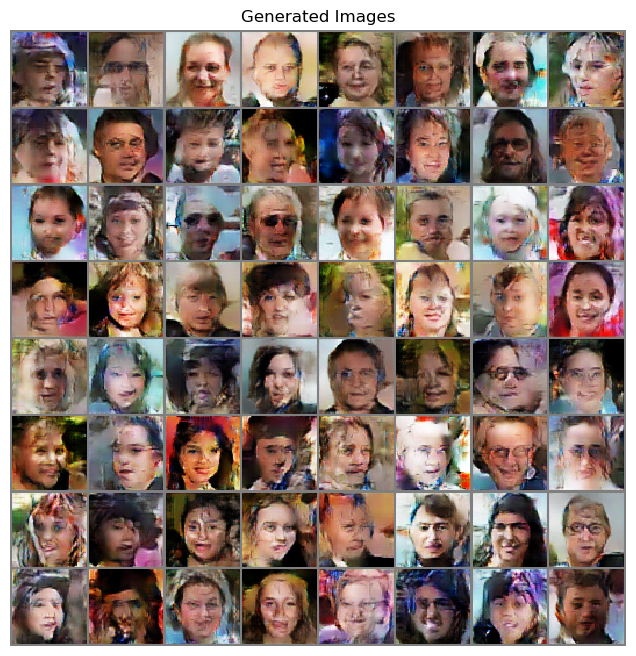

Epoch 10
[100/547]  loss_diff=0.3526 loss_vae=0.0631 loss_d=0.0000 loss_d_eg=0.0672 loss=0.4828
[200/547]  loss_diff=0.3496 loss_vae=0.0288 loss_d=0.0001 loss_d_eg=0.0465 loss=0.4249
[300/547]  loss_diff=0.3299 loss_vae=0.0263 loss_d=0.0001 loss_d_eg=0.0584 loss=0.4146
[400/547]  loss_diff=0.3322 loss_vae=0.0286 loss_d=0.0001 loss_d_eg=0.0504 loss=0.4111
[500/547]  loss_diff=0.3293 loss_vae=0.0255 loss_d=0.0002 loss_d_eg=0.0438 loss=0.3987


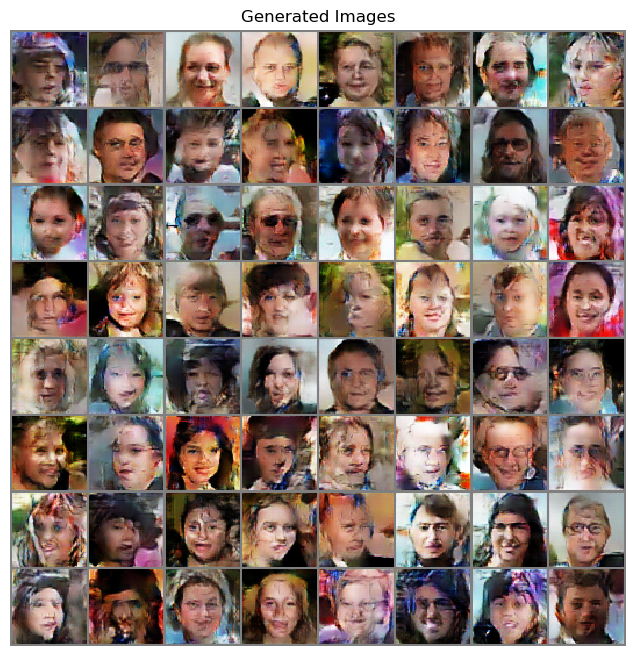

In [5]:
from lpips_pytorch import LPIPS, lpips


def weights_init(m):
    classname = m.__class__.__name__
    if 'BatchNorm' in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.normal_(m.bias.data, 0.0, 0.02)
    elif 'Linear' in classname:
        if 'weight' in m.__dict__ and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.1)
        if 'bias' in m.__dict__ and m.bias is not None:
            nn.init.normal_(m.bias.data, 0.0, 0.1)
    else:
        if 'weight' in m.__dict__ and m.weight is not None:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        if 'bias' in m.__dict__ and m.bias is not None:
            nn.init.normal_(m.bias.data, 0.0, 0.02)


def train_epoch(dataloader, net_e, net_g, net_d, loss_fn, optimizer_e, optimizer_g, optimizer_d):
    for batch, x in enumerate(dataloader, 0):
        net_e.zero_grad()
        net_g.zero_grad()
        net_d.zero_grad()
        real = x.to(device)

        encoded = net_e(real)
        fake = net_g(encoded)

        # loss between real and fake
        loss_diff = 2.0*torch.mean((fake-real)**2)**0.5
        # loss_diff = 0.001*lpips(fake, real, net_type='squeeze', version='0.1')

        # KL divergence loss for VAE
        encoded_mean = torch.mean(encoded, axis=0)
        encoded_cov = torch.cov(encoded.T)
        p1 = torch.distributions.multivariate_normal.MultivariateNormal(
            encoded_mean, encoded_cov)
        p2 = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.zeros_like(encoded_mean, device=device),
            torch.eye(LATENT, device=device))
        loss_vae = 0.01 * torch.distributions.kl_divergence(p1, p2)

        # discriminator loss
        k_loss_d = 0.01
        label = torch.ones((real.size(0),), device=device)
        loss_d_real = k_loss_d*loss_fn(net_d(real).view(-1), label)
        label = torch.zeros((real.size(0),), device=device)
        loss_d_fake = k_loss_d*loss_fn(net_d(fake).view(-1), label)
        loss_d = 0.5*(loss_d_real + loss_d_fake)
        loss_d_eg = k_loss_d * loss_fn(1.0-net_d(fake).view(-1), label)

        # train discriminator
        net_d.zero_grad()
        loss_d.backward(retain_graph=True)
        optimizer_d.step()

        # train encoder/generator
        net_e.zero_grad()
        net_g.zero_grad()
        loss = loss_diff + loss_vae + loss_d_eg
        loss.backward()
        optimizer_e.step()
        optimizer_g.step()

        # output stats
        if (batch+1) % 100 == 0:
            print('[%d/%d]  loss_diff=%.4f loss_vae=%.4f loss_d=%.4f loss_d_eg=%.4f loss=%.4f'
                  % (batch+1, len(dataloader),
                     loss_diff.item(), loss_vae.item(),
                     loss_d.item(), loss_d_eg.item(),
                     loss.item()))


def count_weights(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# load data
dataloader = load_data(FFHQDataset())

# creat models
net_e = Encoder().to(device)
print("Encoder", count_weights(net_e))
print(net_e)

net_g = Generator().to(device)
print("Generator", count_weights(net_g))
print(net_g)

net_d = Discriminator().to(device)
print("Discriminator", count_weights(net_d))
print(net_d)

try:
    net_e.load_state_dict(torch.load(MODEL_E_PATH, map_location=device))
    net_g.load_state_dict(torch.load(MODEL_G_PATH, map_location=device))
    net_d.load_state_dict(torch.load(MODEL_D_PATH, map_location=device))
    print("Model loaded from file.")
except BaseException as e:
    net_e.apply(weights_init)
    net_g.apply(weights_init)
    net_d.apply(weights_init)
    print("Model weights initialized.")

# loss function and optimizer
loss_fn = nn.BCELoss()
optimizer_e = torch.optim.Adam(net_e.parameters(),
                                lr=0.0001, betas=(0.5, 0.999))
optimizer_g = torch.optim.Adam(net_g.parameters(),
                                lr=0.0001, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(net_d.parameters(),
                                lr=0.00005, betas=(0.5, 0.999))

# train with progress
fixed_noise = torch.randn(64, LATENT, device=device)
for epoch in range(1, 10+1):
    # train
    print("Epoch", epoch)
    train_epoch(dataloader, net_e, net_g, net_d, loss_fn, optimizer_e, optimizer_g, optimizer_d)
    # plot
    if epoch % 1 == 0:
        generated = net_g(fixed_noise)
        plt.figure(figsize=(8, 8))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(vutils.make_grid(
            generated,
            padding=2, pad_value=0.5, normalize=True).cpu(), (1, 2, 0)),
                    interpolation='nearest')
        plt.show() # on ipynb

# export weights

torch.save(net_e.state_dict(), MODEL_E_PATH)
torch.save(net_g.state_dict(), MODEL_G_PATH)
torch.save(net_d.state_dict(), MODEL_D_PATH)


In [28]:
param_i = 0
layers = {}
prev_path = None
for layer in net_g.main:
    # print(layer.__class__.__name__)
    if layer.__class__.__name__ == "Linear":
        param_i += 1
        data = list(layer.parameters())[0].data.cpu()
        shape = '_'.join(map(str, data.shape))
        path = EXPORT_PATH+"/w{:02d}_{}.bin".format(param_i, shape)
        layers[path] = data.numpy()
        prev_path = path
    elif layer.__class__.__name__ == "ConvTranspose2d":
        param_i += 1
        data = list(layer.parameters())[0].data.cpu()
        shape = '_'.join(map(str, data.shape))
        path = EXPORT_PATH+"/w{:02d}_{}.bin".format(param_i, shape)
        layers[path] = data.numpy()
        prev_path = path
    elif layer.__class__.__name__ == "BatchNorm2d":
        assert len(layers[prev_path].shape) == 4
        mu = layer.running_mean.cpu()
        var = layer.running_var.cpu()
        invstdev = 1.0 / (var + 1e-5)**0.5
        data = list(layer.parameters())
        gamma, beta = data[0].data.cpu(), data[1].data.cpu()
        a = gamma * invstdev
        b = beta - mu * gamma * invstdev
        a, b = a.numpy(), b.numpy()
        layers[prev_path] = layers[prev_path] * a[:, np.newaxis, np.newaxis]
        # print(a.shape, b.shape, layers[prev_path].shape)
        shape = '_'.join(map(str, b.shape))
        path = EXPORT_PATH+"/b{:02d}_{}.bin".format(param_i, shape)
        layers[path] = b
    else:
        prev_path = None

for path, data in layers.items():
    data.astype(np.float32).tofile(path)